# Predictions API, the model training part

## Loading dataset and taking a look on how the data looks like**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import model_selection
import pickle
import sqlite3
import pandas as pd
database = "database.sqlite"

conn = sqlite3.connect(database)

data = pd.read_sql("select * from passenger_activity_after_registration", con=conn)
print(data)
conn.close()

          id  recency_7  frequency_7  monetary_value_7  frequency_30  \
0          1          1            1               8.5             1   
1          2          1            1              16.3             1   
2          3          1            1               5.6             1   
3          4          1            1              32.0             1   
4          5          1            1              63.6             1   
...      ...        ...          ...               ...           ...   
72753  72754          4            2              32.7             2   
72754  72755          1            2              58.6             2   
72755  72756          2            6              89.9             6   
72756  72757          1            1              25.5             1   
72757  72758          1            1              18.8             1   

       monetary_value_30  
0                    8.5  
1                   16.3  
2                    5.6  
3                   32.0  


### Since the data is not huge, I will proceed with Pandas in model training and not use Spark for ex.

In [2]:
print(data.shape)

(72758, 6)


In [3]:
data.head()

,id,recency_7,frequency_7,monetary_value_7,frequency_30,monetary_value_30
0,1,1,1,8.5,1,8.5
1,2,1,1,16.3,1,16.3
2,3,1,1,5.6,1,5.6
3,4,1,1,32.0,1,32.0
4,5,1,1,63.6,1,63.6


### Removing passenger_id as it will not be of any use in modelling the data, also will remove frequency_30 because it is future knowledge that shouldn't be available before prediction and it is related to 'monetary_value_30' which we will want to predict

In [4]:
data = data.drop(['id', 'frequency_30'], axis=1)

In [5]:
data.dtypes

recency_7              int64
frequency_7            int64
monetary_value_7     float64
monetary_value_30    float64
dtype: object

In [6]:
data['recency_7'].value_counts()

1    45525
2    11409
3     4719
4     3168
7     2958
5     2566
6     2413
Name: recency_7, dtype: int64

### We know already from the feature description that recency_7 is a categorical feature, so let's go ahead and convert it

In [7]:
try:
    data['recency_7'] = data.recency_7.astype('category')
except Exception as err:
    print(err)


### Check that recency_7 has been converted

## Let us check now for missing data

In [8]:
data.isnull().any()

recency_7            False
frequency_7          False
monetary_value_7     False
monetary_value_30    False
dtype: bool

### No missing values, great!

### Now we check each column has wrong enteries. As we know, all columns shouldn't have negative values, as they are frequency or money

1- recency_7

### already checked when converting to categorical

2- frequency_7

In [9]:
sum(data.frequency_7<0)

0

3 - monetary_value_7


In [10]:
sum(data.monetary_value_7<0)

0

4- monetary_value_30


In [11]:
sum(data.monetary_value_30<0)

0

### So all columns are already clean with no missing and no wrong enteries that we can detect

## Now to calculate correlation between features to analyze and select suitable features. 
### Since we have categorical and numerical features, I used pearson correlation in case we are correlation two numerical features, and used cramers for correlating two categorical features (not my code - not used here) and finally eta for correlating numerical features with categorical

In [12]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def eta__correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements.iloc[np.argwhere(fcat == i).flatten()].values
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

corr_matrix = pd.DataFrame(np.nan, index=data.columns, columns=data.columns)
for row in corr_matrix.index:
    for col in corr_matrix.columns:
        if "category" in data.dtypes[row].name and "category" in data.dtypes[col].name:
            #cramers_v category correlation
            confusion_matrix = pd.crosstab(data[row], data[col]).values
            corr_matrix[col][row] = cramers_v(confusion_matrix)
        elif "category" in data.dtypes[row].name:
            #eta category-numerical correlation
            corr_matrix[col][row] = eta__correlation_ratio(data[row].tolist(), data[col])
        elif "category" in data.dtypes[col].name:
            #eta category-numerical correlation
            corr_matrix[col][row] = eta__correlation_ratio(data[col].tolist(), data[row])
        else:
            #pearson correlation for numerical-numerical coorelation
            corr_matrix[col][row] = data[row].corr(data[col])

### Visualizing the correaltion matrix using a heatmap

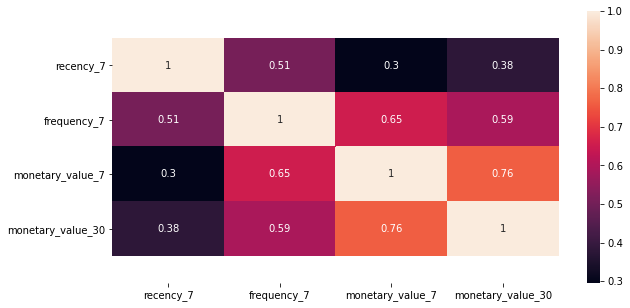

In [13]:
plt.figure(figsize=(10,5))
sn.heatmap(corr_matrix, annot=True)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

### As expected, monetary_value_7 is highly correlated to monetary_value_30, because intuitevly most of the customers having high usages in 7 days would have high usages in 30 days

## A fast outlier analysis

[Text(0.5, 1.0, 'Boxplot for monetary_value_30')]

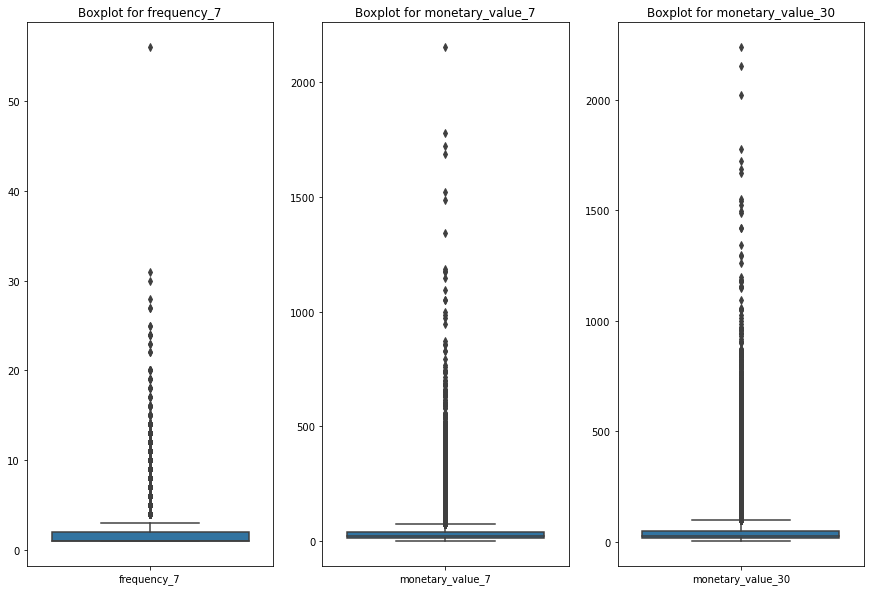

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,10))

sn.boxplot(data=data[['frequency_7']], ax=axs[0])
axs[0].set(title="Boxplot for frequency_7")

sn.boxplot(data=data[['monetary_value_7']], ax=axs[1])
axs[1].set(title="Boxplot for monetary_value_7")

sn.boxplot(data=data[['monetary_value_30']], ax=axs[2])
axs[2].set(title="Boxplot for monetary_value_30")

### The maximum value in frequency_7 looks like an extreme outlier, however the overall picture of all columns looks fine

### Checking the extreme outlier

In [15]:
data[data['frequency_7']>50]

,recency_7,frequency_7,monetary_value_7,monetary_value_30
22445,7,56,870.2,869.2


### Looks like a valid point, will not remove

### Before model fit, we have to convert the categorical features into one-hot encoding representation.**

In [16]:
def convert_hot_encoder(df):
    columns_to_encode = []
    def to_hot_encoder(df, column_to_remove):       
        df = pd.concat([df, pd.get_dummies(df[column_to_remove], prefix=column_to_remove, drop_first=False)],axis=1)
        df = df.drop([column_to_remove], axis=1)
        return df

    for col in df.columns:
        if "category" in df.dtypes[col].name:
            columns_to_encode.append(col)
            
    for column in columns_to_encode:
        df = to_hot_encoder(df, column)
    return df

data_one_hot = convert_hot_encoder(data)


display(data_one_hot.tail())

,frequency_7,monetary_value_7,monetary_value_30,recency_7_1,recency_7_2,recency_7_3,recency_7_4,recency_7_5,recency_7_6,recency_7_7
72753,2,32.7,32.7,0,0,0,1,0,0,0
72754,2,58.6,58.6,1,0,0,0,0,0,0
72755,6,89.9,89.9,0,1,0,0,0,0,0
72756,1,25.5,25.5,1,0,0,0,0,0,0
72757,1,18.8,18.8,1,0,0,0,0,0,0


### Split to training, val and test

In [17]:
from sklearn.model_selection import train_test_split

data_train_one_hot, data_test_one_hot =\
train_test_split(data_one_hot, test_size=0.2)
data_train_one_hot, data_val_one_hot =\
train_test_split(data_train_one_hot, test_size=0.25)

### Split to features and target

In [18]:
y_train = data_train_one_hot[['monetary_value_30']].to_numpy().flatten()
x_train = data_train_one_hot.drop(['monetary_value_30'], axis=1).to_numpy()

y_val = data_val_one_hot[['monetary_value_30']].to_numpy().flatten()
x_val = data_val_one_hot.drop(['monetary_value_30'], axis=1).to_numpy()

y_test = data_test_one_hot[['monetary_value_30']].to_numpy().flatten()
x_test = data_test_one_hot.drop(['monetary_value_30'], axis=1).to_numpy()

### Normalize features using MinMaxScaler from sklearn

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# fit and transform the data
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

pickle.dump(scaler, open('fitted_scaler.pkl', 'wb'))

In [34]:
x_test.shape

(14552, 9)

## Now train a neural network for the regression task (predicting "monetary_value_30")

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.callbacks import Callback, ModelCheckpoint, TensorBoard, LearningRateScheduler, EarlyStopping
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras import backend as K


def R2_coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred)) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()))


model_nn = Sequential()
model_nn.add(Dense(500, activation='relu', input_shape=(x_train_scaled.shape[1],)))
model_nn.add(Dense(300, activation='relu'))
model_nn.add(Dense(200, activation='relu'))
model_nn.add(Dense(50, activation='relu'))
model_nn.add(Dense(1))

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,\
                               patience=200, restore_best_weights=True)

for layer in model_nn.layers:
    print("Input shape: "+str(layer.input_shape)+". Output shape: "+str(layer.output_shape))
model_nn.compile(loss='mean_squared_error', optimizer='adam', metrics = [R2_coeff_determination])
history =model_nn.fit(x_train_scaled, y_train, validation_data=(x_val_scaled, y_val),
                epochs=500,
                batch_size=1000,
                shuffle=True,
                verbose=1, callbacks = [early_stopping]).history

predictions_test_nn = model_nn.predict(x_test_scaled).flatten()
R2_score_nn = R2_coeff_determination(K.constant(y_test),predictions_test_nn).numpy()
print("mean squared error and R2 score between predictions and actual values on testset are respectively {:.2f}\
 and {:.4f} ".format(((y_test - predictions_test_nn)**2).mean(), R2_score_nn))

Input shape: (None, 9). Output shape: (None, 500)
Input shape: (None, 500). Output shape: (None, 300)
Input shape: (None, 300). Output shape: (None, 200)
Input shape: (None, 200). Output shape: (None, 50)
Input shape: (None, 50). Output shape: (None, 1)
Epoch 1/500
44/44 [==============================] - 9s 17ms/step - loss: 5846.5591 - R2_coeff_determination: -0.3141 - val_loss: 3944.3281 - val_R2_coeff_determination: 0.1853
Epoch 2/500
44/44 [==============================] - 0s 10ms/step - loss: 3624.4720 - R2_coeff_determination: 0.1855 - val_loss: 3626.3594 - val_R2_coeff_determination: 0.2498
Epoch 3/500
44/44 [==============================] - 0s 9ms/step - loss: 3292.8786 - R2_coeff_determination: 0.2750 - val_loss: 2594.4475 - val_R2_coeff_determination: 0.4516
Epoch 4/500
44/44 [==============================] - 0s 9ms/step - loss: 2177.6905 - R2_coeff_determination: 0.5138 - val_loss: 1967.1461 - val_R2_coeff_determination: 0.5739
Epoch 5/500
44/44 [========================

Epoch 46/500
44/44 [==============================] - 0s 9ms/step - loss: 1663.8135 - R2_coeff_determination: 0.6506 - val_loss: 1812.4269 - val_R2_coeff_determination: 0.6068
Epoch 47/500
44/44 [==============================] - 0s 9ms/step - loss: 1934.4258 - R2_coeff_determination: 0.6119 - val_loss: 1804.1066 - val_R2_coeff_determination: 0.6075
Epoch 48/500
44/44 [==============================] - 0s 9ms/step - loss: 1753.7369 - R2_coeff_determination: 0.6065 - val_loss: 1815.1967 - val_R2_coeff_determination: 0.6048
Epoch 49/500
44/44 [==============================] - 0s 10ms/step - loss: 1793.5302 - R2_coeff_determination: 0.6302 - val_loss: 1807.4867 - val_R2_coeff_determination: 0.6090
Epoch 50/500
44/44 [==============================] - 0s 10ms/step - loss: 1764.0781 - R2_coeff_determination: 0.6172 - val_loss: 1843.7411 - val_R2_coeff_determination: 0.5990
Epoch 51/500
44/44 [==============================] - 0s 9ms/step - loss: 1692.1070 - R2_coeff_determination: 0.6248 -

44/44 [==============================] - 0s 10ms/step - loss: 1646.0773 - R2_coeff_determination: 0.6301 - val_loss: 1842.0640 - val_R2_coeff_determination: 0.6005
Epoch 93/500
44/44 [==============================] - 0s 9ms/step - loss: 1842.3235 - R2_coeff_determination: 0.6208 - val_loss: 1867.9542 - val_R2_coeff_determination: 0.5961
Epoch 94/500
44/44 [==============================] - 0s 9ms/step - loss: 1863.7071 - R2_coeff_determination: 0.6343 - val_loss: 1810.4913 - val_R2_coeff_determination: 0.6078
Epoch 95/500
44/44 [==============================] - 0s 9ms/step - loss: 1764.3420 - R2_coeff_determination: 0.6321 - val_loss: 1815.2506 - val_R2_coeff_determination: 0.6072
Epoch 96/500
44/44 [==============================] - 0s 10ms/step - loss: 1775.9494 - R2_coeff_determination: 0.6272 - val_loss: 1827.0839 - val_R2_coeff_determination: 0.6048
Epoch 97/500
44/44 [==============================] - 0s 10ms/step - loss: 1665.2689 - R2_coeff_determination: 0.6306 - val_loss: 1

44/44 [==============================] - 0s 10ms/step - loss: 1696.9585 - R2_coeff_determination: 0.6289 - val_loss: 1858.6439 - val_R2_coeff_determination: 0.5955
Epoch 185/500
44/44 [==============================] - 0s 10ms/step - loss: 1743.7877 - R2_coeff_determination: 0.6086 - val_loss: 1839.7955 - val_R2_coeff_determination: 0.6013
Epoch 186/500
44/44 [==============================] - 0s 10ms/step - loss: 1636.8335 - R2_coeff_determination: 0.6342 - val_loss: 1837.1230 - val_R2_coeff_determination: 0.6005
Epoch 187/500
44/44 [==============================] - 0s 10ms/step - loss: 1551.7424 - R2_coeff_determination: 0.6357 - val_loss: 1842.8417 - val_R2_coeff_determination: 0.5986
Epoch 188/500
44/44 [==============================] - 0s 11ms/step - loss: 1687.0228 - R2_coeff_determination: 0.6138 - val_loss: 1897.8557 - val_R2_coeff_determination: 0.5913
Epoch 189/500
44/44 [==============================] - 0s 10ms/step - loss: 1620.6950 - R2_coeff_determination: 0.6251 - val

### So R^2 value on the testset is around 0.66. There is no much overfitting but there is a siginifcant underfitting that I couldn't combat using a deeper network. Probably because of there is only 3 features and it could be that they don't fully relate to the label we want to predict. Intuitevly the usage of the user over 30 days can be influenced by many things.

## Just to try out different regressors fast using sklearn to see if they can do better, plus using cross-validaiton

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor, ElasticNetCV
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

models = [LinearRegression(),
          Ridge(),
          HuberRegressor(),
          ElasticNetCV(),
          DecisionTreeRegressor(), 
          ExtraTreesRegressor(),
          GradientBoostingRegressor(),
          RandomForestRegressor(),
          BaggingRegressor(),
          GradientBoostingRegressor()]

models_scores = pd.DataFrame(columns = ['Model', 'Score'])

def test_algorithms(model):
    kfold = model_selection.KFold(n_splits=10)
    predicted = model_selection.cross_val_score(model, x_train_scaled, y_train, cv=kfold, scoring='neg_mean_squared_error')
    score=abs(predicted.mean())
    return score

best_score=100000
best_model_sk=[]
for model in models:
    print(model)
    score=test_algorithms(model)
    models_scores  = models_scores.append({'Model': model, 'Score': score}, ignore_index = True)
    if abs(score)<best_score:
        best_score=abs(score)
        best_model_sk=model
        
best_model_sk.fit(x_train_scaled, y_train)
predictions_test_sk = best_model_sk.predict(x_train_scaled).flatten()
R2_score_sk = R2_coeff_determination(K.constant(y_train),predictions_test_sk).numpy()
print("mean squared error and R2 score between predictions and actual values on testset are respectively {:.2f}\
 and {:.4f} ".format(((y_train - predictions_test_sk)**2).mean(), R2_score_sk))

LinearRegression()
Ridge()
HuberRegressor()


/Users/abdullahsalama/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abdullahsalama/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abdullahsalama/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERAT

ElasticNetCV()
DecisionTreeRegressor()
ExtraTreesRegressor()
GradientBoostingRegressor()
RandomForestRegressor()
BaggingRegressor()
GradientBoostingRegressor()
mean squared error and R2 score between predictions and actual values on testset are respectively 1529.76 and 0.6731 


### Finally, if the R2 score of the Neural Network (NN) model trained is better than the other regressor models, then save the NN model, otherwise save the best model.

In [29]:
if R2_score_nn > R2_score_sk:
    pickle.dump(model_nn, open('trained_model.pkl', 'wb'))
else:
    pickle.dump(best_model_sk, open('trained_model.pkl', 'wb'))
    